**Import Modules**

In [ ]:
import numpy as np
import pandas as pn
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm.notebook import tqdm #this give the process bar while loading
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input

**Load the Dataset**

In [5]:
Base_Dir='/kaggle/input/utkface-new/UTKFace/'

In [6]:
# labels - age, gender, ethnicity
image_paths=[]
age_labels=[]
gender_labels=[]
for filename in tqdm(os.listdir(Base_Dir)):
    image_path=os.path.join(Base_Dir,filename)
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
# convert to dataframe
df=pn.DataFrame()
df['image'],df['age'],df['gender']=image_paths,age_labels,gender_labels
df.head()

image  age  gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1

In [8]:
# map labels for gender
gender_dict={0:'Male',1:'Female'}


**Exploratory Data Analysis**

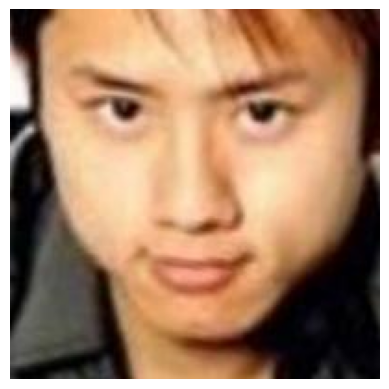

In [9]:
from PIL import Image
img=Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

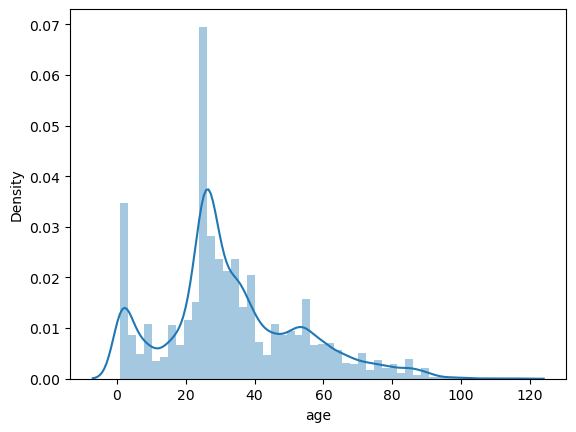

In [10]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

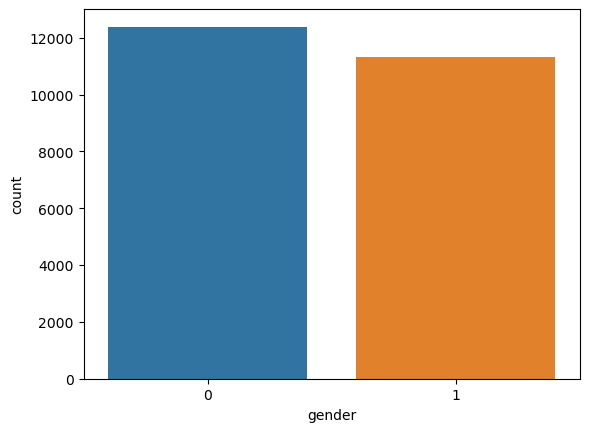

In [11]:
sns.countplot(x=df['gender'])

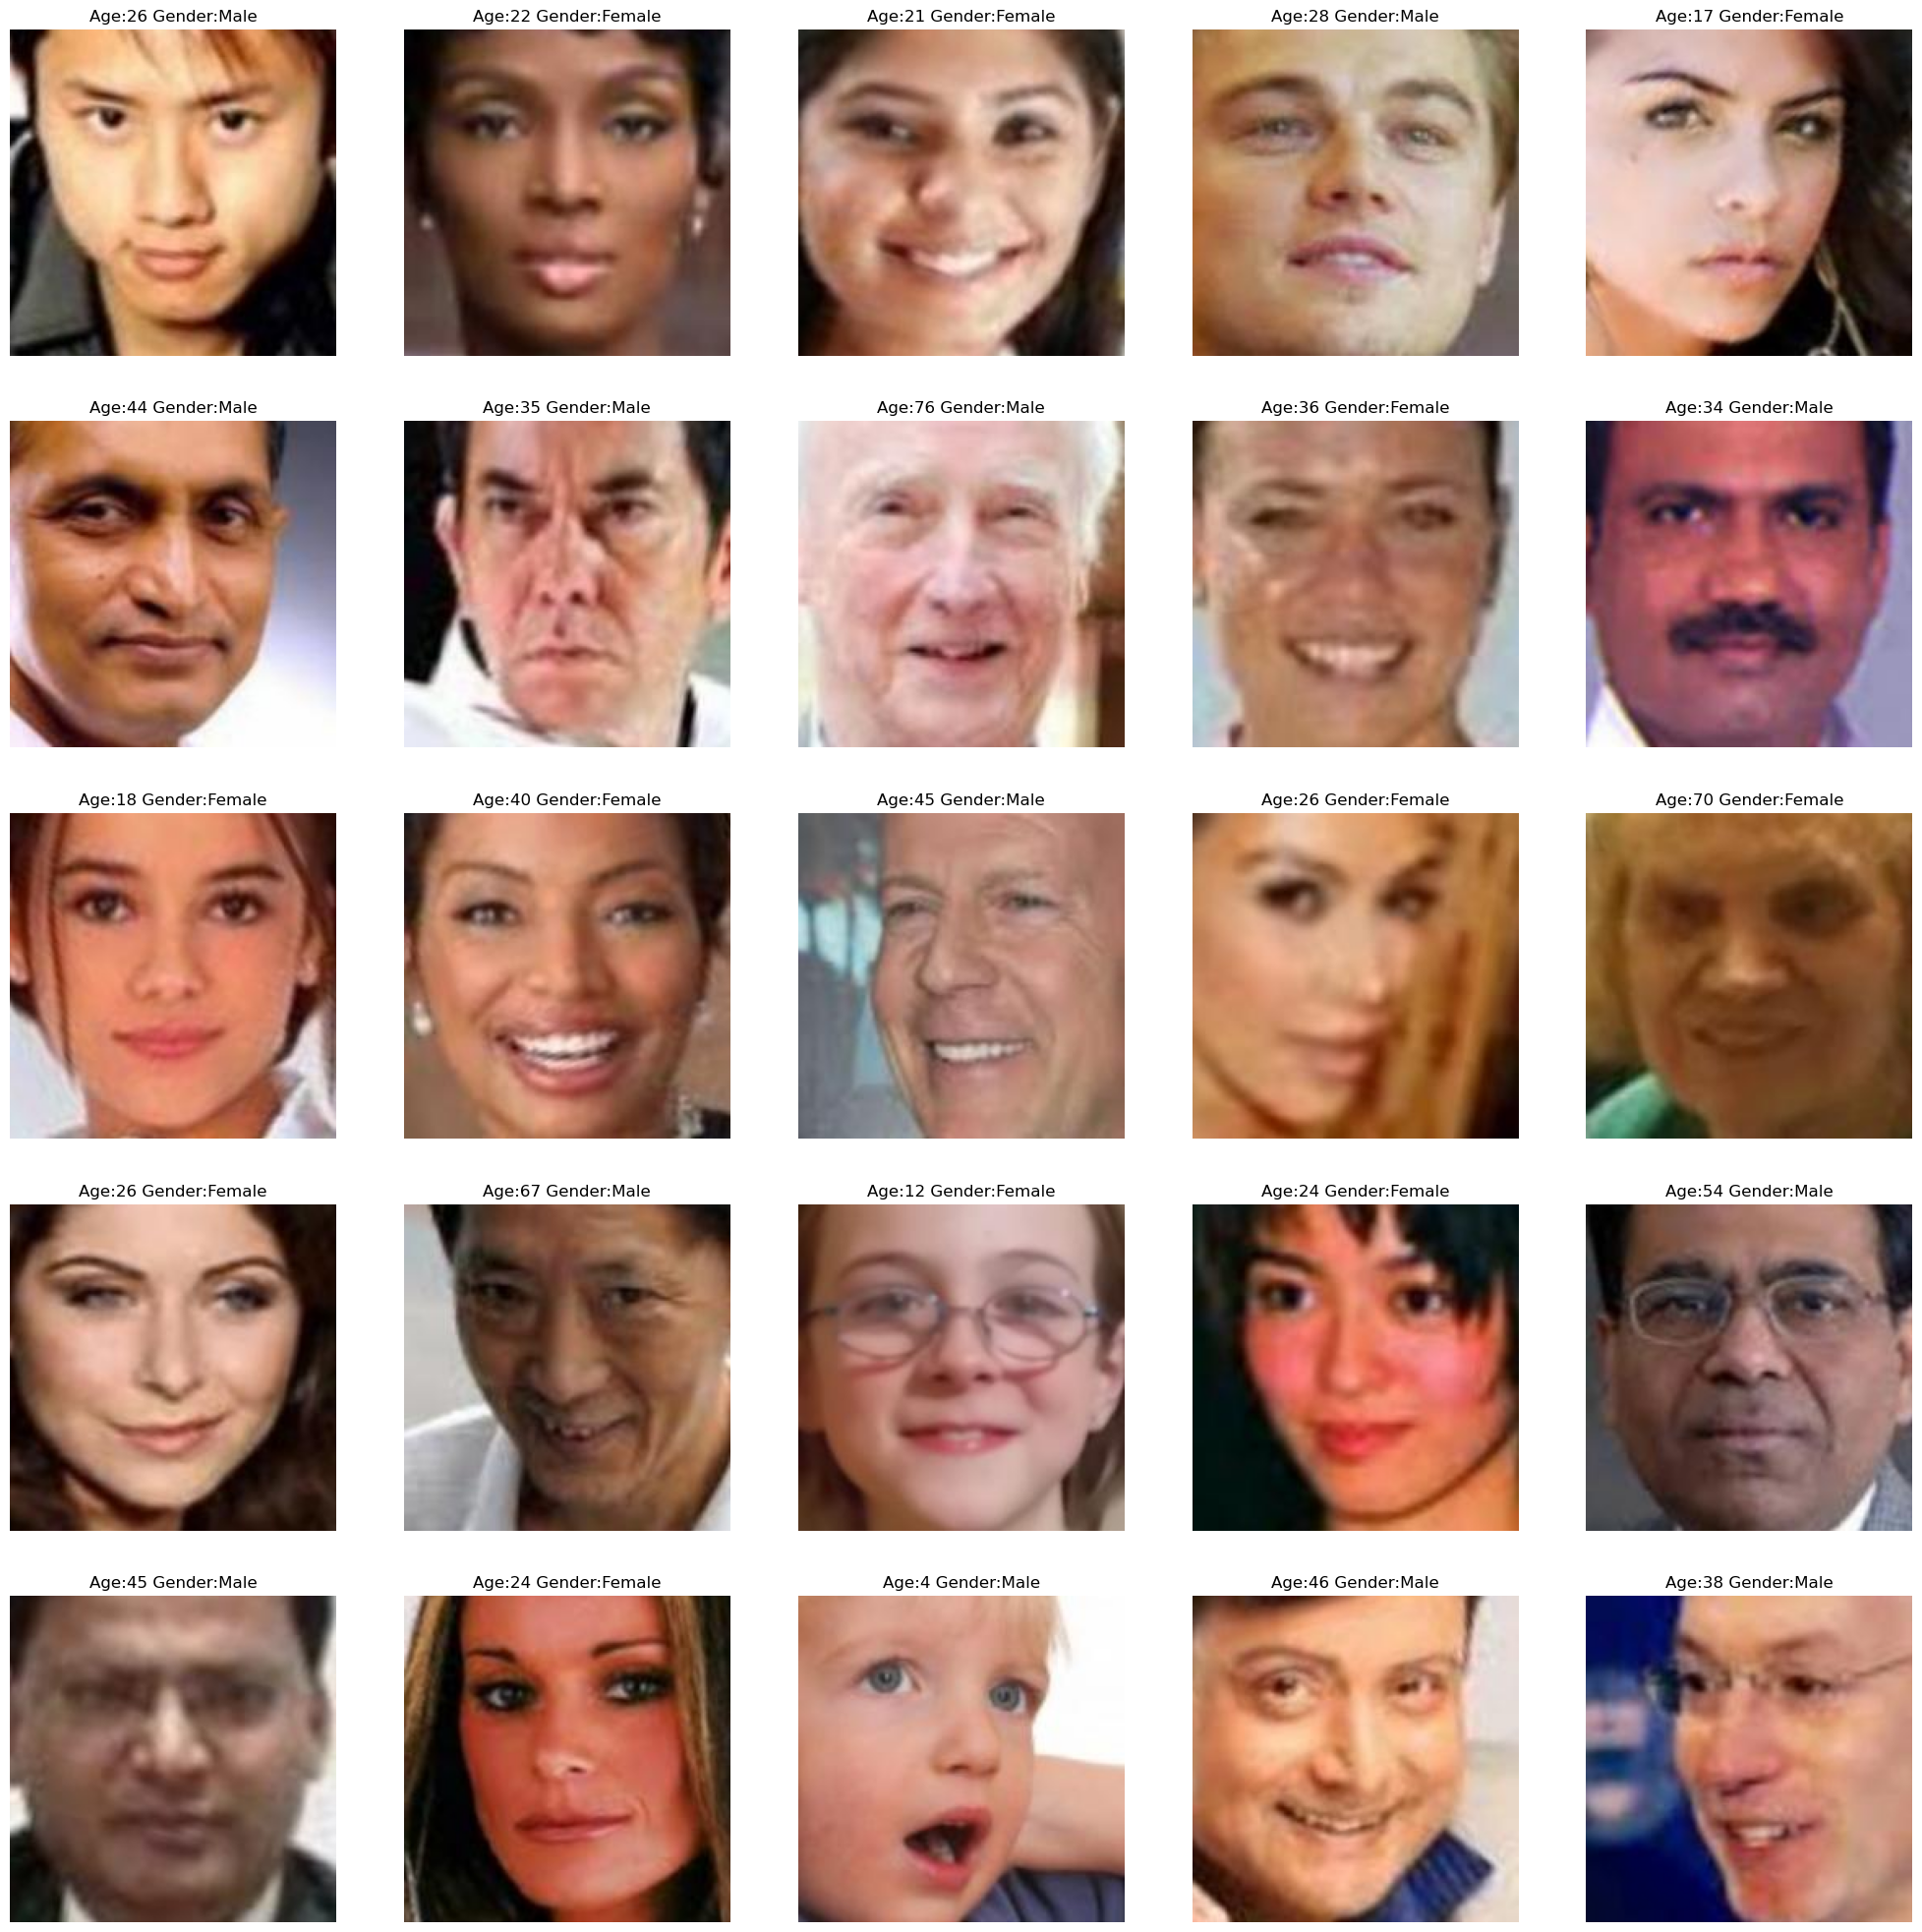

In [12]:
# to display grid of images
plt.figure(figsize=(25,25))
files=df.iloc[0:25]
for index,file,age,gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis("off")

**Feature Extraction**

In [13]:
def extract_features(images):
    features=[]
    for image in tqdm(images):
        img=load_img(image,grayscale=True)
        img=img.resize((128,128),Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)#we are using greyscale
    features=np.array(features)
    features=features.reshape(len(features),128,128,1)
    return features

In [14]:
x=extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
x.shape

(23708, 128, 128, 1)

In [16]:
# normalize the images
x=x/252.0

In [17]:
y_gender=np.array(df['gender'])
y_age=np.array(df['age'])

In [18]:
input_shape=(128,128,1)


**Model Creation**

In [23]:
inputs=Input((input_shape))
# convolutional layers
conv_1=Conv2D(32,kernel_size=(3,3),activation='relu')(inputs)
max_1=MaxPooling2D(pool_size=(2,2))(conv_1)

conv_2=Conv2D(64,kernel_size=(3,3),activation='relu')(max_1)
max_2=MaxPooling2D(pool_size=(2,2))(conv_2)

conv_3=Conv2D(128,kernel_size=(3,3),activation='relu')(max_2)
max_3=MaxPooling2D(pool_size=(2,2))(conv_3)

conv_4=Conv2D(256,kernel_size=(3,3),activation='relu')(max_3)
max_4=MaxPooling2D(pool_size=(2,2))(conv_4)
flatten=Flatten()(max_4)

# fully connected layers

dense_1=Dense(256,activation='relu')(flatten)
dense_2=Dense(256,activation='relu')(flatten)

dropout_1=Dropout(0.3)(dense_1)
dropout_2=Dropout(0.3)(dense_2)

output_1=Dense(1,activation='sigmoid',name='gender_out')(dropout_1)
output_2=Dense(1,activation='relu',name='age_out')(dropout_2)

model=Model(inputs=[inputs],outputs=[output_1,output_2])
model.compile(loss=['binary_crossentropy','mae'],optimizer='adam',metrics=['accuracy'])

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 126, 126, 32  320         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_7[0][0]']               
                                                                                            

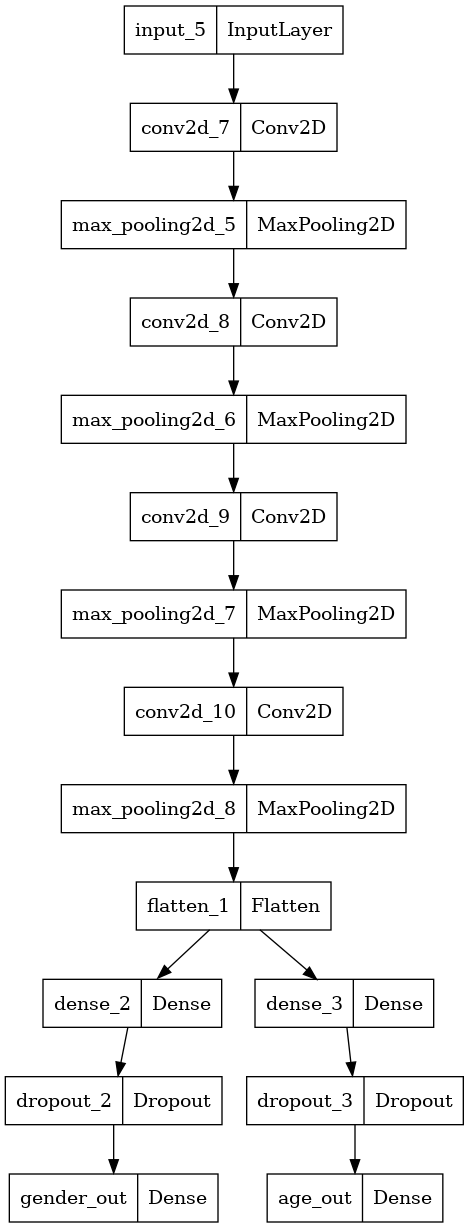

In [25]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [26]:
# train model
history=model.fit(x=x,y=[y_gender,y_age],batch_size=32,epochs=30,validation_split=0.2)

Epoch 1/30
593/593 [==============================] - 30s 22ms/step - loss: 15.7000 - gender_out_loss: 0.6643 - age_out_loss: 15.0357 - gender_out_accuracy: 0.5732 - age_out_accuracy: 0.0473 - val_loss: 13.1750 - val_gender_out_loss: 0.5757 - val_age_out_loss: 12.5994 - val_gender_out_accuracy: 0.7212 - val_age_out_accuracy: 0.0460
Epoch 2/30
593/593 [==============================] - 12s 20ms/step - loss: 11.4753 - gender_out_loss: 0.4680 - age_out_loss: 11.0073 - gender_out_accuracy: 0.7775 - age_out_accuracy: 0.0311 - val_loss: 9.9128 - val_gender_out_loss: 0.4079 - val_age_out_loss: 9.5049 - val_gender_out_accuracy: 0.8172 - val_age_out_accuracy: 0.0209
Epoch 3/30
593/593 [==============================] - 12s 20ms/step - loss: 9.8175 - gender_out_loss: 0.3980 - age_out_loss: 9.4195 - gender_out_accuracy: 0.8160 - age_out_accuracy: 0.0193 - val_loss: 9.1290 - val_gender_out_loss: 0.3670 - val_age_out_loss: 8.7620 - val_gender_out_accuracy: 0.8319 - val_age_out_accuracy: 0.0135
Epoc

**Plot the Results**

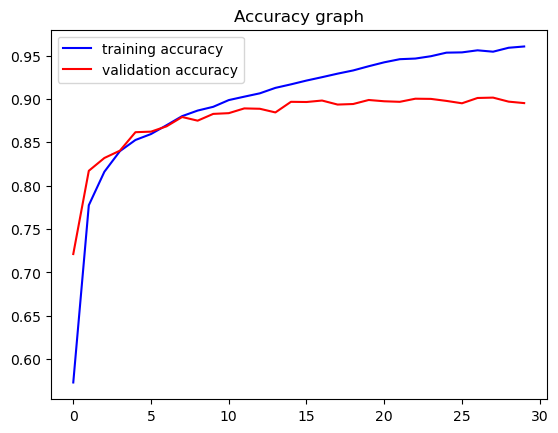

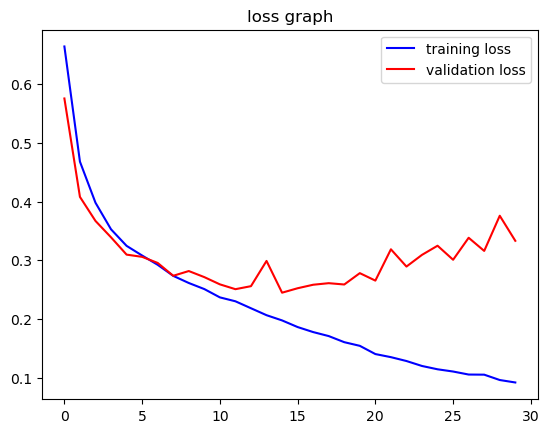

In [32]:
# plot results for gender
acc=history.history['gender_out_accuracy']
val_acc=history.history['val_gender_out_accuracy']
epochs=range(len(acc))

plt.plot(epochs,acc,'b',label='training accuracy')
plt.plot(epochs,val_acc,'r',label='validation accuracy')
plt.title('Accuracy graph')
plt.legend()

plt.figure()

loss=history.history['gender_out_loss']
val_loss=history.history['val_gender_out_loss']

plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('loss graph')
plt.legend()

plt.show()

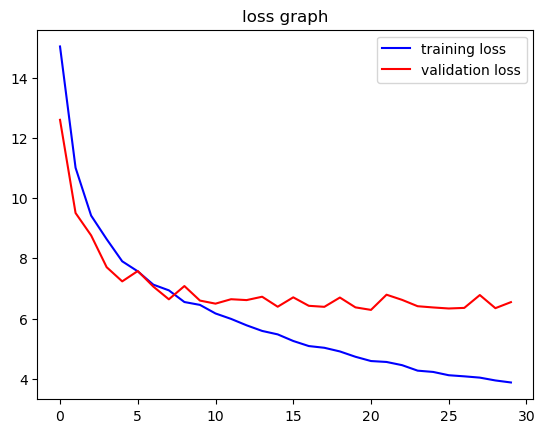

In [33]:
#plot for age
loss=history.history['age_out_loss']
val_loss=history.history['val_age_out_loss']
epochs=range(len(loss))
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.title('loss graph')
plt.legend()

plt.show()

**Prediction with Test Data**

original gender Female original age 3
1/1 [==============================] - 0s 20ms/step
predicted gender Female predicted age 2


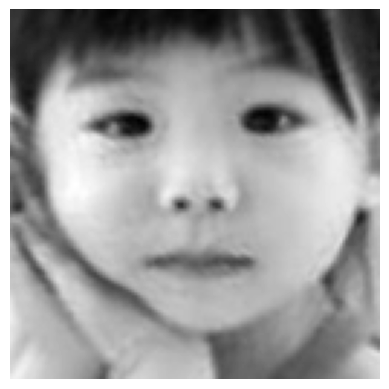

In [38]:
image_index=100
print('original gender',gender_dict[y_gender[image_index]],"original age",y_age[image_index])

# predict from model

pred=model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("predicted gender",pred_gender,"predicted age",pred_age)
plt.axis("off")
plt.imshow(x[image_index].reshape(128,128),cmap='gray');

original gender Female original age 40
1/1 [==============================] - 0s 20ms/step
predicted gender Female predicted age 34


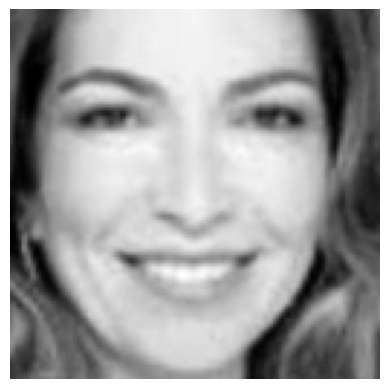

In [42]:
image_index=143
print('original gender',gender_dict[y_gender[image_index]],"original age",y_age[image_index])
# predict from model

pred=model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("predicted gender",pred_gender,"predicted age",pred_age)
plt.axis("off")
plt.imshow(x[image_index].reshape(128,128),cmap='gray');

original gender Female original age 26
1/1 [==============================] - 0s 22ms/step
predicted gender Female predicted age 24


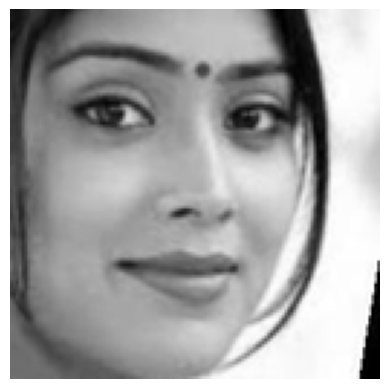

In [40]:
image_index=5000
print('original gender',gender_dict[y_gender[image_index]],"original age",y_age[image_index])
# predict from model

pred=model.predict(x[image_index].reshape(1,128,128,1))
pred_gender=gender_dict[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("predicted gender",pred_gender,"predicted age",pred_age)
plt.axis("off")
plt.imshow(x[image_index].reshape(128,128),cmap='gray');